## FreqPulse-VAE: A Frequency-Conditioned Variational Autoencoder for Pulsatile Signal Generation

In [1]:
import os
import numpy as np
import pandas as pd
import yaml
from tqdm import trange, tqdm
from functools import reduce
from scipy import stats
import itertools

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, GRU, Dense, Masking, Reshape, Flatten, RepeatVector, TimeDistributed, Bidirectional, Activation, GaussianNoise, Lambda, LSTM
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from Models.MainModel import *
from Utilities.Utilities import *
from Utilities.EvaluationModules import *
from Models.Losses import *

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

def read_yaml(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

#### Env setting

In [2]:
ConfigName = 'SKZFC_ART_50_800'


if 'ART' in ConfigName:
    LoadConfig = 'Config' + 'ART'
elif 'PLETH' in ConfigName:
    LoadConfig = 'Config' + 'PLETH'
elif 'II' in ConfigName:
    LoadConfig = 'Config' + 'II'
else:
    assert False, "Please verify if the data type is properly included in the name of the configuration. The configuration name should be structured as 'Config' + 'data type', such as ConfigART."

yaml_path = './Config/'+LoadConfig+'.yml'

SavePath = './Results/'
ConfigSet = read_yaml(yaml_path)

### Model related parameters
SigType = ConfigSet[ConfigName]['SigType']
LatDim = ConfigSet[ConfigName]['LatDim']
CompSize = ConfigSet[ConfigName]['CompSize']

MaskingRate = ConfigSet[ConfigName]['MaskingRate']
NoiseStd = ConfigSet[ConfigName]['NoiseStd']
MaskStd = ConfigSet[ConfigName]['MaskStd']
ReparaStd = ConfigSet[ConfigName]['ReparaStd']
FcLimit = ConfigSet[ConfigName]['FcLimit']
DecayH = ConfigSet[ConfigName]['DecayH']
DecayL = ConfigSet[ConfigName]['DecayL']
ReparaStd = 10
BatchSize = 10000

ModelName = ConfigName+'.hdf5'
### Model checkpoint
ModelSaveName = SavePath+ModelName


### Data

In [3]:
TrData = np.load('./Data/ProcessedData/Tr'+str(SigType)+'.npy')
ValData = np.load('./Data/ProcessedData/Val'+str(SigType)+'.npy')

SigDim = ValData.shape[1]
DataSize = ValData.shape[0]

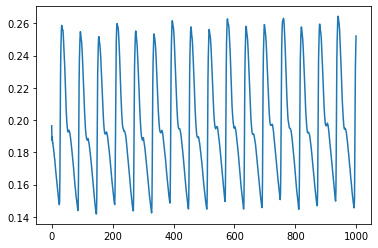

In [4]:
plt.plot(ValData[9])

### Post model

In [4]:
# Defining Modesl
EncModel = Encoder(SigDim=SigDim, LatDim= LatDim, Type = '', MaskingRate = MaskingRate, NoiseStd = NoiseStd, MaskStd = MaskStd, ReparaStd = ReparaStd, Reparam=True, FcLimit=FcLimit)
FeatExtModel = FeatExtractor(SigDim=SigDim, CompSize = CompSize, DecayH=DecayH, DecayL=DecayL)
FeatGenModel = FeatGenerator(SigDim=SigDim,FeatDim=FeatExtModel.output[1].shape[-1], LatDim= LatDim)
ReconModel = Reconstructor(SigDim=SigDim, FeatDim=FeatExtModel.output[1].shape[-1])

Models = [EncModel,FeatExtModel,FeatGenModel,ReconModel] 

# Adding losses
SigRepModel = TCLosses(Models, DataSize, ConfigSet[ConfigName])


### Load weights
SigRepModel.load_weights(ModelSaveName)

### Regularizer resetting
for i in SigRepModel.weights:
    if i.name.split('/')[0] in ['Beta_Z','Beta_Fc','Beta_TC', 'Beta_MI' ,'Beta_Orig', 'Beta_Feat']:
        i.assign(1.)
        
## Model Compile
SigRepModel.compile(optimizer='adam') 
SigRepModel.summary()

## The model for evaluation
RecOut = ReconModel(FeatGenModel.output)
GenModel = Model(FeatGenModel.input, RecOut)

OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp_Enc (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf.signal.frame (TFOpLambda)    (None, 20, 50)       0           Inp_Enc[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 20, 50)       11550       tf.signal.frame[0][0]            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 50)       11550       bidirectional[0][0]              
____

In [10]:
def LocCandZs (FreqZs_Idx, Mode_Value, SumH, Samp_Z, NMiniBat, NGen):
    
    for Freq, _ in FreqZs_Idx.items():
        Mode_Idx = np.where(Mode_Value == Freq)[0]

        # Skipping the remainder of the code if there are no mode values present at the predefined frequencies.
        if len(Mode_Idx) <1: 
            continue;

        # Calculating the minimum of sum of H (Min_SumH) and Candidate Z-values(CandZs)
        Min_SumH_Idx = np.argmin(SumH[Mode_Idx])
        Min_SumH = np.min(SumH[Mode_Idx])
        CandZs = Samp_Z.reshape(NMiniBat, NGen, -1)[[Mode_Idx[Min_SumH_Idx]]]

        # Updating the Min_SumH value if the current iteration value is smaller.
        if Min_SumH < FreqZs_Idx[Freq][0]:
            FreqZs_Idx[Freq] = [Min_SumH, CandZs]
    
    return FreqZs_Idx


def FFT_PS(Data, Metric, ReturnMode=False, MinFreq = 1, MaxFreq = 51):
    # Power Spectral Density
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
    PSD = (FFTRes**2)/FFTRes.shape[-1]
    
    # Probability Density Function
    PSPDF = PSD / np.sum(PSD, axis=(1, 2),keepdims=True)
    
    # Power Spectral Entropy
    PSE = -np.sum(PSPDF * np.log(PSPDF), axis=-1)
    # Probability Density Function for Power Spectral Entropy
    PSEPDF = PSE / np.sum(PSE, axis=(-1),keepdims=True)
    
    
    if 'PSD' in Metric:
        Value = PSD
    elif 'PSPDF' in Metric:
        Value = PSPDF
        
    # The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
    Max_Value_Label = np.argmax(Value, axis=-1) + 1
    ### Calculating mode values of MaxV_NG_ZFc
    Mode_Value = stats.mode(Max_Value_Label.T, axis=0, keepdims=False)[0] 
    ### (NMiniBat, Frequency_idx, NGen)
    TransValue = np.transpose(Value, (0, 2,1))
    #### Selecting variance values by the order of NMiniBat and Frequency_idx; To index the max frequency, 1 is subtracted from the modes.
    Max_Value = TransValue[np.arange(NMiniBat), Mode_Value - 1]
    
    
    if 'PSD' == Metric:
        # (NMiniBat, NGen, NFreq)
        Output = PSD
    elif 'PSPDF'  == Metric:
        # (NMiniBat, NGen, NFreq)
        Output = PSPDF
    elif 'PSE'  == Metric:
        # (NMiniBat, NFreq)
        Output = PSE
    elif 'PSEPDF' == Metric:
        # (NMiniBat, NFreq)
        Output = PSEPDF
    elif 'Max_PSD' == Metric:
        # (NMiniBat, NFreq)
        Output = Max_Value
    elif 'Max_PSPDF' == Metric:
        # (NMiniBat, NFreq)
        Output = Max_Value
    
    if ReturnMode == True:
        return Output, Mode_Value
    else:
        return Output
    
    
def ProbPermutation(Data, Nframe=3, EpsProb = 1e-7):
    
    # Generate true permutation cases
    TruePerms = np.concatenate(list(itertools.permutations(np.arange(Nframe)))).reshape(-1, Nframe)

    # Get all permutation cases
    Data_Ext = tf.signal.frame(Data, frame_length=Nframe, frame_step=1, axis=-1)
    PermsTable =  np.argsort(Data_Ext, axis=-1)

    CountPerms = 1- (TruePerms[None,None] == PermsTable[:,:,None])
    CountPerms = 1-np.sum(CountPerms, axis=-1).astype('bool')
    CountPerms = np.sum(CountPerms, axis=(1))
    ProbCountPerms = CountPerms / np.sum(CountPerms, axis=-1, keepdims=True)
    
    return np.maximum(ProbCountPerms, EpsProb)    



def ProbFreq (Data, NMiniBat, NGen, Axis,  Metric ='PSD', MinFreq = 1, MaxFreq = 51, EpsProb = 1e-7):

    ### Conducting FFT 
    # Power Spectral Density
    PSD = FFT_PS(Data, Metric=Metric, MinFreq = MinFreq, MaxFreq = MaxFreq)

    ### Max PSD label
    MaxPSDLabel = np.argmax(PSD, axis=-1) + 1
    MaxVLabelIDX =  np.arange(MaxFreq - MinFreq) + 1

    if Axis =='All':
        # The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
        MaxVLabelCount = np.zeros_like(MaxVLabelIDX)
        MaxV, Count = np.unique(MaxPSDLabel, return_counts=True)
        MaxVLabelCount[MaxV] = Count

        ### Probability of frequencies 
        Prob = MaxVLabelCount / np.sum(MaxVLabelCount)

    elif Axis =='One':
        MaxVLabelCount = []
        # Mini batch-wise max freqeuncy count
        for num, mini in enumerate(MaxPSDLabel):
        
            Count_ = np.zeros_like(MaxVLabelIDX)
            MaxV, Count = np.unique(mini, return_counts=True)
            Count_[MaxV] = Count
            MaxVLabelCount.append(Count_[None])

        # (Batch_size, N_frequency)
        MaxVLabelCount = np.concatenate(MaxVLabelCount)    
        Prob = MaxVLabelCount / NGen 
    
    return np.maximum(Prob, EpsProb)
    
    
def Sampler (Data):
    #Z_Mu_Out = SigRepModel.get_layer('Z_Mu').output
    Zs_Out = SigRepModel.get_layer('Zs').output
    #Z_Sigma_Out = SigRepModel.get_layer('Z_Log_Sigma').output
    #FCs_Out = SigRepModel.get_layer('FCs').output
    Sampler = Model(EncModel.input, Zs_Out)
    return Sampler.predict(Data, batch_size=BatchSize, verbose=1)   

In [6]:
MaxFreq = 51
MinFreq = 1
NMiniBat = 500
SimSize = 1
MinFreqR=0.
MaxFreqR=0.05
NGen = 100
Ndata = len(ValData)
MASize = Ndata//NMiniBat
AnalData = ValData
NFCs = SigRepModel.get_layer('FCs').output.shape[-1]
NSelZ = 1
FCmuEps = 0.05

### The ratio of the max Power Spectral Density (PSD) value according to the given frequency.

(array([  185.,  4230.,  9098.,  8822.,  9638., 10768.,  9314.,  5947.,
         1863.,   135.]),
 array([0.16154048, 0.23948884, 0.31743719, 0.39538555, 0.47333391,
        0.55128227, 0.62923063, 0.70717898, 0.78512734, 0.8630757 ,
        0.94102406]),
 <BarContainer object of 10 artists>)

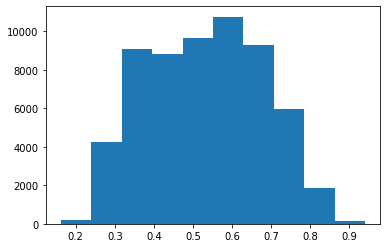

In [7]:
Data = ValData
HalfLen = Data.shape[-1]//2
FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
PSD = (FFTRes**2)/FFTRes.shape[-1]
PSD_Dist = np.max(PSD, axis=-1) / np.sum(PSD, axis=-1)
plt.hist(PSD_Dist, bins=10)

In [ ]:
FC_Arange_ = np.tile(np.linspace(MinFreqR, MaxFreqR, NGen )[:, None], (1,NFCs))
 

### monte carlo approximation
I_V_Z = 0
I_V_ZjZ = 0
I_V_Zj = 0
I_V_FRZj = 0
I_V_FAZj = 0
I_VE_FMZj = 0
I_VE_FAZj = 0


FreqZs_Idx =  {i:[np.inf] for i in range(1, MaxFreq - MinFreq + 2)}

for sim in range(SimSize):
    
    SplitData = np.array_split(AnalData, MASize)
    with trange(MASize, leave=False) as t:

        for mini in range(MASize):
            #print(sim, mini, MASize)
          
            print('Sampling Samp_Zs and Samp_Fc')
            # Sampling
            SplitData_Ext =  np.broadcast_to(SplitData[mini][:, None], (NMiniBat, NGen, SplitData[mini].shape[-1])).reshape(-1, SplitData[mini].shape[-1])
            Samp_Z = Sampler(SplitData_Ext)
            FCs = np.random.rand(NMiniBat *NGen, NFCs) * FcLimit
            
            print('Setting SigGen_ZFc')
            # Reconstruction; y ~ Q(Y | Z, Fc)Q(Z, Fc | Y)
            
            print('Setting SigGen_ZjFc')
            # Masking for selecting Samp_Zj from Samp_Z by assuming Zs with indices other than j have mean values '0' of Guassian dist.
            Mask_Z = np.zeros((NMiniBat*NGen, LatDim))
            for i in range(NMiniBat*NGen):
                Mask_Z[i, np.random.choice(LatDim, NSelZ,replace=False )] = 1
            Samp_Zj = Samp_Z * Mask_Z
            
            
            print('Setting SigGen_ZjFcRPT')            
            # Selecting Samp_Zj from Guassian dist by assuming Zs with indices other than j have mean values '0' of Guassian dist and repeat the values NGen times.
            Samp_ZjRPT = []
            for i in range(NMiniBat):
                Mask_Z = np.zeros((LatDim))
                # LatDim-wise Z sampling
                Mask_Z[ np.random.choice(LatDim, NSelZ,replace=False )]= np.random.normal(0, ReparaStd)
                # Setting the same Z value within the N generated signals (NGen).
                Samp_ZjRPT.append(np.broadcast_to(Mask_Z[None], (NGen,LatDim))[None]) 
            Samp_ZjRPT = np.concatenate(Samp_ZjRPT).reshape(NMiniBat *NGen, LatDim)
            
            
            print('Setting SigGen_ZjFcAr')
            # Reconstruction; y ~ P(Y | Fc, Zj)Q(Zj); 
            # The Fc values on FC_Arange (FcAr) are generated based on the linspace with a fixed interval.
            FC_Arange = np.broadcast_to(FC_Arange_[None], (NMiniBat, NGen, NFCs)).reshape(-1, NFCs)
            
            
            print('Setting SigGen_ZjFcMu')
            # Reconstruction; y ~ P(Y | Zj, Fc)Q(Z)Q(j)Q(Fc); j~U() Fc~U() and Z~N(0, std) 
            # Assuming all FC_μ x FcLimit + eps, FC_μ=0.5, eps ~ N(0, 0.5*FcLimit*FCmuEps)
            Rand_FCs = np.zeros_like(FCs) + FcLimit * 0.5 + np.random.normal(0, (FcLimit * 0.5)*FCmuEps, (FCs.shape))
            
            # Signal generation
            Set_FCs = np.concatenate([FCs,FCs,FCs,FC_Arange,Rand_FCs])
            Set_Zs = np.concatenate([Samp_Z,Samp_Zj,Samp_ZjRPT,Samp_ZjRPT,Samp_ZjRPT])
            Set_Pred = GenModel.predict([Set_FCs[:, :2], Set_FCs[:, 2:], Set_Zs], batch_size=BatchSize, verbose=1).reshape(-1, NMiniBat, NGen, AnalData.shape[-1])
            SigGen_ZFc, SigGen_ZjFc, SigGen_ZjFcRPT, SigGen_ZjFcAr, SigGen_ZjFcMu = [np.squeeze(SubPred) for SubPred in np.split(Set_Pred, 5) ]  
                             
                
            # Max frequency wise values
            Q_V = ProbFreq (SigGen_ZFc, NMiniBat, NGen, 'All', Metric='PSD',  MinFreq = 1, MaxFreq = 51)
            Q_V_Z = ProbFreq (SigGen_ZFc, NMiniBat, NGen, 'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_Zj = ProbFreq (SigGen_ZjFc, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_ZjFR = ProbFreq (SigGen_ZjFcRPT, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            Q_V_ZjFA = ProbFreq (SigGen_ZjFcAr, NMiniBat, NGen,'One', Metric='PSD', MinFreq = 1, MaxFreq = 51)
            
            
            
            # Max frequency entropy-wise values
            MaxPSD_ZjFcRPT = FFT_PS(SigGen_ZjFcRPT, 'Max_PSD', MinFreq = 1, MaxFreq = 51)
            MaxPSD_ZjFcMu = FFT_PS(SigGen_ZjFcMu, 'Max_PSD', MinFreq = 1, MaxFreq = 51)
            MaxPSD_ZjFcAr = FFT_PS(SigGen_ZjFcAr, 'Max_PSD', MinFreq = 1, MaxFreq = 51)

            
            # Calculate the permutation entropy based on the PSD values of the frequency with the max PSD from generated signals.
            Q_VE = ProbPermutation(MaxPSD_ZjFcRPT, Nframe=3)
            Q_VE_ZjFM = ProbPermutation(MaxPSD_ZjFcMu, Nframe=3)
            Q_VE_ZjFA = ProbPermutation(MaxPSD_ZjFcAr, Nframe=3)


            
            # I(V;Z)
            I_V_Z_ = np.mean(np.sum(Q_V_Z * np.log(Q_V_Z / Q_V[None]), axis=-1))
            print('I_V_Z : ', I_V_Z_)
            I_V_Z += I_V_Z_
            
            # I(V;Zj|Z)
            I_V_ZjZ_ = np.mean(np.sum(Q_V_Zj * np.log(Q_V_Zj / Q_V_Z), axis=-1))
            print('I_V_ZjZ : ', I_V_ZjZ_)
            I_V_ZjZ += I_V_ZjZ_
                        
            
            # I(V;Zj)
            I_V_FRZj_ = np.mean(np.sum(Q_V_ZjFR * np.log(Q_V_ZjFR / Q_V), axis=-1))
            print('I_V_FRZj : ', I_V_FRZj_)
            I_V_FRZj += I_V_FRZj_
            
            # I(V;FC|Zj)
            I_V_FAZj_ = np.mean(np.sum(Q_V_ZjFA * np.log(Q_V_ZjFA / Q_V_ZjFR), axis=-1))
            print('I_V_FAZj : ', I_V_FAZj_)
            I_V_FAZj += I_V_FAZj_
                        
            # I(VE;Zj)
            I_VE_FMZj_ = np.mean(np.sum(Q_VE_ZjFM * np.log(Q_VE_ZjFM / Q_VE), axis=-1))
            print('I_VE_FMZj : ', I_VE_FMZj_)
            I_VE_FMZj += I_VE_FMZj_
            
            # I(VE;FC|Zj)
            I_VE_FAZj_ = np.mean(np.sum(Q_VE_ZjFA * np.log(Q_VE_ZjFA / Q_VE_ZjFM), axis=-1))
            print('I_VE_FAZj : ', I_VE_FAZj_)
            I_VE_FAZj += I_VE_FAZj_
            
            
            # Locating the candidate Z values that generate good signals.
            H_V_ZjFA = -np.sum(Q_V_ZjFA * np.log(Q_V_ZjFA), axis=-1)
            H_VE_ZjFA = -np.sum(Q_VE_ZjFA * np.log(Q_VE_ZjFA), axis=-1)
            SumH_ZjFA = H_V_ZjFA + H_VE_ZjFA
            
            _, Mode_Value = FFT_PS (SigGen_ZjFcAr,ReturnMode=True, Metric='PSD', MinFreq = 1, MaxFreq = 51)
            FreqZs_Idx = LocCandZs (FreqZs_Idx, Mode_Value, SumH_ZjFA, Samp_ZjRPT, NMiniBat, NGen)
            print(FreqZs_Idx[7])
            
            
            t.update(1)


# CMI(V;Zj, Z)
I_V_Z /= (MASize*SimSize)
I_V_ZjZ /= (MASize*SimSize)
CMI_V_ZjZ = I_V_Z + I_V_ZjZ             

# CMI(V;FC,Zj)
I_V_FRZj /= (MASize*SimSize)
I_V_FAZj /= (MASize*SimSize)
CMI_V_FCZj = I_V_FRZj + I_V_FAZj             

# CMI(VE;FA,FM)
I_VE_FMZj /= (MASize*SimSize)
I_VE_FAZj /= (MASize*SimSize)
CMI_VE_FAFM = I_VE_FMZj + I_VE_FAZj             


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 48ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 115ms/step
I_V_Z :  0.1209615509880661
I_V_ZjZ :  1.3089103218851084
I_V_FRZj :  2.5986274421177233
I_V_FAZj :  0.19157335550673163
I_VE_FMZj :  0.03450039632982107
I_VE_FAZj :  0.8171294747614699


  1%|▋                                                                                 | 1/120 [00:14<29:41, 14.97s/it]

[1.802119077564763, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 66ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 103ms/step
I_V_Z :  0.11658955163979315
I_V_ZjZ :  1.307090563578772
I_V_FRZj :  2.5976466270692837
I_V_FAZj :  0.21294093334800826
I_VE_FMZj :  0.03693577076438713
I_VE_FAZj :  0.8225935329443681


  2%|█▎                                                                                | 2/120 [00:29<28:37, 14.55s/it]

[1.313620195521386, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 62ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 107ms/step
I_V_Z :  0.11864269368915695
I_V_ZjZ :  1.318773077536798
I_V_FRZj :  2.627887804609687
I_V_FAZj :  0.22031303513895464
I_VE_FMZj :  0.03799018867686598
I_VE_FAZj :  0.818253168958199


  2%|██                                                                                | 3/120 [00:44<28:41, 14.71s/it]

[1.313620195521386, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 39ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step
I_V_Z :  0.11951690326521577
I_V_ZjZ :  1.3559344887427187
I_V_FRZj :  2.5931560829554763
I_V_FAZj :  0.22910283052732455
I_VE_FMZj :  0.0353085793683832
I_VE_FAZj :  0.8161282420256016


  3%|██▋                                                                               | 4/120 [00:58<28:09, 14.57s/it]

[1.313620195521386, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 47ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 102ms/step
I_V_Z :  0.12166504595949763
I_V_ZjZ :  1.3174126425567019
I_V_FRZj :  2.6298155630307662
I_V_FAZj :  0.2131238654157169
I_VE_FMZj :  0.03677913791899756
I_VE_FAZj :  0.8199116720530508


  4%|███▍                                                                              | 5/120 [01:12<27:29, 14.35s/it]

[1.2994950724697745, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 44ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 117ms/step
I_V_Z :  0.11925937927971222
I_V_ZjZ :  1.3219091943223111
I_V_FRZj :  2.583897561004218
I_V_FAZj :  0.2608045745593515
I_VE_FMZj :  0.035202270818514694
I_VE_FAZj :  0.8074885682847939


  5%|████                                                                              | 6/120 [01:27<27:48, 14.63s/it]

[1.2994950724697745, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 68ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 118ms/step
I_V_Z :  0.11999796494479262
I_V_ZjZ :  1.3181721469692056
I_V_FRZj :  2.558069176467391
I_V_FAZj :  0.21545856896946838
I_VE_FMZj :  0.036820670826018836
I_VE_FAZj :  0.8043826743325758


  6%|████▊                                                                             | 7/120 [01:42<27:25, 14.56s/it]

[1.2994950724697745, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 66ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 114ms/step
I_V_Z :  0.11997342119866215
I_V_ZjZ :  1.29390648243028
I_V_FRZj :  2.556394648679877
I_V_FAZj :  0.23963926654255127
I_VE_FMZj :  0.0340488243425198
I_VE_FAZj :  0.8048132176678183


  7%|█████▍                                                                            | 8/120 [01:57<27:34, 14.77s/it]

[1.2994950724697745, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 48ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 115ms/step
I_V_Z :  0.1185265493589087
I_V_ZjZ :  1.3141947689093523
I_V_FRZj :  2.6969213383274915
I_V_FAZj :  0.18953743004834944
I_VE_FMZj :  0.03604564502122552
I_VE_FAZj :  0.8098859419566978


  8%|██████▏                                                                           | 9/120 [02:11<27:02, 14.62s/it]

[1.2994950724697745, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 36ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 117ms/step
I_V_Z :  0.12165156770132961
I_V_ZjZ :  1.319708538867342
I_V_FRZj :  2.5824442382187116
I_V_FAZj :  0.21140247147090072
I_VE_FMZj :  0.03709076171517266
I_VE_FAZj :  0.8171969929804577


  8%|██████▊                                                                          | 10/120 [02:25<26:35, 14.50s/it]

[1.27282339058832, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 115ms/step
I_V_Z :  0.1173071386751011
I_V_ZjZ :  1.2777267334513138
I_V_FRZj :  2.646404987927301
I_V_FAZj :  0.24925401306196485
I_VE_FMZj :  0.03578094532678
I_VE_FAZj :  0.7775909917324747


  9%|███████▍                                                                         | 11/120 [02:41<26:46, 14.74s/it]

[1.1297607537561125, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 51ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 112ms/step
I_V_Z :  0.12077159898124577
I_V_ZjZ :  1.2882252529475882
I_V_FRZj :  2.56207886973342
I_V_FAZj :  0.25313483156925687
I_VE_FMZj :  0.03531319824257233
I_VE_FAZj :  0.8425064440499076


 10%|████████                                                                         | 12/120 [02:55<26:15, 14.59s/it]

[1.1297607537561125, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 47ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step
I_V_Z :  0.12120490535271856
I_V_ZjZ :  1.3425832988840052
I_V_FRZj :  2.5549217794145678
I_V_FAZj :  0.19207153341177371
I_VE_FMZj :  0.037612473827957786
I_VE_FAZj :  0.8601452171543829


 11%|████████▊                                                                        | 13/120 [03:10<26:19, 14.76s/it]

[1.1297607537561125, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 47ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 114ms/step
I_V_Z :  0.11819808470492552
I_V_ZjZ :  1.3506401190856154
I_V_FRZj :  2.6470508916876443
I_V_FAZj :  0.2112526529878981
I_VE_FMZj :  0.03866259865948773
I_VE_FAZj :  0.8200044171085366


 12%|█████████▍                                                                       | 14/120 [03:24<25:48, 14.60s/it]

[1.1297607537561125, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 35ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 115ms/step
I_V_Z :  0.1171860798929652
I_V_ZjZ :  1.3363715335861512
I_V_FRZj :  2.5734466935425964
I_V_FAZj :  0.2033475588463378
I_VE_FMZj :  0.03389728881363152
I_VE_FAZj :  0.7822200311813259


 12%|██████████▏                                                                      | 15/120 [03:38<25:22, 14.50s/it]

[1.1297607537561125, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 56ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 118ms/step
I_V_Z :  0.11886691183712039
I_V_ZjZ :  1.3254903829826687
I_V_FRZj :  2.580162154647426
I_V_FAZj :  0.2385406772822581
I_VE_FMZj :  0.034282474909108594
I_VE_FAZj :  0.806013059911719


 13%|██████████▊                                                                      | 16/120 [03:54<25:31, 14.73s/it]

[1.1297607537561125, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 47ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 2s 100ms/step
I_V_Z :  0.11822734354821318
I_V_ZjZ :  1.2960987409742553
I_V_FRZj :  2.653348806955053
I_V_FAZj :  0.17783160666896605
I_VE_FMZj :  0.03543557588788319
I_VE_FAZj :  0.8309532244587889


 14%|███████████▍                                                                     | 17/120 [04:08<24:56, 14.53s/it]

[1.1297607537561125, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 59ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 2s 98ms/step
I_V_Z :  0.11781686332439842
I_V_ZjZ :  1.2817463341304074
I_V_FRZj :  2.5856165367254644
I_V_FAZj :  0.21180097023387667
I_VE_FMZj :  0.03735355613719166
I_VE_FAZj :  0.8449018450202489


 15%|████████████▏                                                                    | 18/120 [04:22<24:28, 14.40s/it]

[1.1297607537561125, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 47ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 108ms/step
I_V_Z :  0.12105002886038234
I_V_ZjZ :  1.362990886520184
I_V_FRZj :  2.682808974235542
I_V_FAZj :  0.21385411524663914
I_VE_FMZj :  0.03672954189256092
I_VE_FAZj :  0.8120794819723391


 16%|████████████▊                                                                    | 19/120 [04:37<24:32, 14.58s/it]

[1.1297607537561125, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 52ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 117ms/step
I_V_Z :  0.11964393226349898
I_V_ZjZ :  1.3183981628603234
I_V_FRZj :  2.6083351053187576
I_V_FAZj :  0.22983239551744128
I_VE_FMZj :  0.03758884662246599
I_VE_FAZj :  0.8009596105671459


 17%|█████████████▌                                                                   | 20/120 [04:51<24:10, 14.50s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 33ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 116ms/step
I_V_Z :  0.11737505411618485
I_V_ZjZ :  1.2538783685294461
I_V_FRZj :  2.6364332743562664
I_V_FAZj :  0.2680359844814197
I_VE_FMZj :  0.03524345304473576
I_VE_FAZj :  0.8028552455406691


 18%|██████████████▏                                                                  | 21/120 [05:06<24:12, 14.67s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 53ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 105ms/step
I_V_Z :  0.11691848705480709
I_V_ZjZ :  1.290822016649397
I_V_FRZj :  2.6344133645919494
I_V_FAZj :  0.22348596237653595
I_VE_FMZj :  0.03656897615564996
I_VE_FAZj :  0.8197099462289847


 18%|██████████████▊                                                                  | 22/120 [05:20<23:41, 14.51s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 64ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 121ms/step
I_V_Z :  0.12037130282675261
I_V_ZjZ :  1.3243578096152901
I_V_FRZj :  2.5626958271347338
I_V_FAZj :  0.21124387525530916
I_VE_FMZj :  0.035883389739766514
I_VE_FAZj :  0.8065900958788454


 19%|███████████████▌                                                                 | 23/120 [05:35<23:28, 14.52s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 35ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step
I_V_Z :  0.1182069839175341
I_V_ZjZ :  1.2917483882297283
I_V_FRZj :  2.608697984887472
I_V_FAZj :  0.18879457426355284
I_VE_FMZj :  0.0351070050485673
I_VE_FAZj :  0.8052818855401892


 20%|████████████████▏                                                                | 24/120 [05:50<23:35, 14.75s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 63ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 117ms/step
I_V_Z :  0.11910612003632144
I_V_ZjZ :  1.3323580861334448
I_V_FRZj :  2.5989380634271875
I_V_FAZj :  0.22564160291374735
I_VE_FMZj :  0.036948318032091566
I_VE_FAZj :  0.805721068397118


 21%|████████████████▉                                                                | 25/120 [06:05<23:11, 14.65s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 61ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 116ms/step
I_V_Z :  0.11954359184866899
I_V_ZjZ :  1.3173222571695113
I_V_FRZj :  2.6098075001116086
I_V_FAZj :  0.2555286785516539
I_VE_FMZj :  0.03736393702371521
I_VE_FAZj :  0.8274414283209225


 22%|█████████████████▌                                                               | 26/120 [06:20<23:13, 14.82s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 107ms/step
I_V_Z :  0.11846522599617794
I_V_ZjZ :  1.2949125594448823
I_V_FRZj :  2.6055027381631253
I_V_FAZj :  0.17879621133741772
I_VE_FMZj :  0.03871291105652803
I_VE_FAZj :  0.8214480138122541


 22%|██████████████████▏                                                              | 27/120 [06:34<22:39, 14.62s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 47ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 115ms/step
I_V_Z :  0.1191059742139624
I_V_ZjZ :  1.32315278833965
I_V_FRZj :  2.6393407592571565
I_V_FAZj :  0.2218426458674411
I_VE_FMZj :  0.03522094397056409
I_VE_FAZj :  0.8218360932846679


 23%|██████████████████▉                                                              | 28/120 [06:48<22:15, 14.51s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 41ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 118ms/step
I_V_Z :  0.11732543130245128
I_V_ZjZ :  1.2740827624210673
I_V_FRZj :  2.580739891458359
I_V_FAZj :  0.2569498594141671
I_VE_FMZj :  0.03474230103551645
I_VE_FAZj :  0.8137995935700003


 24%|███████████████████▌                                                             | 29/120 [07:04<22:20, 14.73s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 46ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 116ms/step
I_V_Z :  0.11895071075675491
I_V_ZjZ :  1.3182903327359585
I_V_FRZj :  2.5924554291403967
I_V_FAZj :  0.24617175707374195
I_VE_FMZj :  0.036590307216058306
I_VE_FAZj :  0.8103714667643067


 25%|████████████████████▎                                                            | 30/120 [07:18<21:55, 14.62s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 115ms/step
I_V_Z :  0.11887491463170677
I_V_ZjZ :  1.323284135253697
I_V_FRZj :  2.638784573550216
I_V_FAZj :  0.203553863435003
I_VE_FMZj :  0.035211348517734616
I_VE_FAZj :  0.8099764135819286


 26%|████████████████████▉                                                            | 31/120 [07:33<21:53, 14.76s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 32ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step
I_V_Z :  0.11747800246012065
I_V_ZjZ :  1.2873027042375547
I_V_FRZj :  2.614112886564694
I_V_FAZj :  0.20546764364400796
I_VE_FMZj :  0.037315267555224976
I_VE_FAZj :  0.8004976742136726


 27%|█████████████████████▌                                                           | 32/120 [07:47<21:26, 14.62s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 120ms/step
I_V_Z :  0.11968174191633449
I_V_ZjZ :  1.3215295601669126
I_V_FRZj :  2.684188299910285
I_V_FAZj :  0.185404672073236
I_VE_FMZj :  0.037372164880271876
I_VE_FAZj :  0.8237262396845925


 28%|██████████████████████▎                                                          | 33/120 [08:02<21:08, 14.58s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 64ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 109ms/step
I_V_Z :  0.12007569994706242
I_V_ZjZ :  1.2989347731871352
I_V_FRZj :  2.594153900537478
I_V_FAZj :  0.22718141487215643
I_VE_FMZj :  0.03683489226842933
I_VE_FAZj :  0.817602053943399


 28%|██████████████████████▉                                                          | 34/120 [08:17<21:07, 14.74s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 46ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 118ms/step
I_V_Z :  0.1193964527334772
I_V_ZjZ :  1.3200306728503848
I_V_FRZj :  2.6564434383219755
I_V_FAZj :  0.25426268572713034
I_VE_FMZj :  0.036126141950750756
I_VE_FAZj :  0.8159370553718702


 29%|███████████████████████▋                                                         | 35/120 [08:31<20:44, 14.64s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 47ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 118ms/step
I_V_Z :  0.12068890632040784
I_V_ZjZ :  1.3555976335975184
I_V_FRZj :  2.5983254759898156
I_V_FAZj :  0.23488561549861958
I_VE_FMZj :  0.03712518291644794
I_VE_FAZj :  0.8447525772474191


 30%|████████████████████████▎                                                        | 36/120 [08:46<20:44, 14.81s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 43ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step
I_V_Z :  0.11646533590252087
I_V_ZjZ :  1.286307406406114
I_V_FRZj :  2.6313347812993753
I_V_FAZj :  0.2009414969295418
I_VE_FMZj :  0.03585192151764416
I_VE_FAZj :  0.8301598607943184


 31%|████████████████████████▉                                                        | 37/120 [09:01<20:19, 14.69s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 44ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step
I_V_Z :  0.1176742626961658
I_V_ZjZ :  1.3012948147151635
I_V_FRZj :  2.641219379800524
I_V_FAZj :  0.21868539819843605
I_VE_FMZj :  0.03516783965538002
I_VE_FAZj :  0.8352826399801494


 32%|█████████████████████████▋                                                       | 38/120 [09:15<19:57, 14.60s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 117ms/step
I_V_Z :  0.11873946136701043
I_V_ZjZ :  1.305135071190313
I_V_FRZj :  2.6069440333209912
I_V_FAZj :  0.2583553331189447
I_VE_FMZj :  0.03423813186949273
I_VE_FAZj :  0.8363895744371849


 32%|██████████████████████████▎                                                      | 39/120 [09:30<19:54, 14.75s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 33ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 119ms/step
I_V_Z :  0.11969413512084902
I_V_ZjZ :  1.3309077755760896
I_V_FRZj :  2.666069136631544
I_V_FAZj :  0.19922711697880197
I_VE_FMZj :  0.03524648798422134
I_VE_FAZj :  0.8281927801781782


 33%|███████████████████████████                                                      | 40/120 [09:45<19:31, 14.64s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 3s 50ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 105ms/step
I_V_Z :  0.11723943490932284
I_V_ZjZ :  1.274872638370891
I_V_FRZj :  2.6786300003904864
I_V_FAZj :  0.2339410466251718
I_VE_FMZj :  0.03624303830081665
I_VE_FAZj :  0.809814186642064


 34%|███████████████████████████▋                                                     | 41/120 [10:00<19:27, 14.78s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 46ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 108ms/step
I_V_Z :  0.11877125157142106
I_V_ZjZ :  1.3008706711767135
I_V_FRZj :  2.6326334913626255
I_V_FAZj :  0.2046511583129
I_VE_FMZj :  0.03691948185138321
I_VE_FAZj :  0.8135290651172064


 35%|████████████████████████████▎                                                    | 42/120 [10:14<18:58, 14.60s/it]

[1.0509808093591861, array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])]
Sampling Samp_Zs and Samp_Fc
5/5 [==============================] - 2s 44ms/step
Setting SigGen_ZFc
Setting SigGen_ZjFc
Setting SigGen_ZjFcRPT
Setting SigGen_ZjFcAr
Setting SigGen_ZjFcMu
25/25 [==============================] - 3s 121ms/step


In [25]:
for Freq, _ in FreqZs_Idx.items():
    Mode_Idx = np.where(Mode_Value == Freq)[0]
    
    # Skipping the remainder of the code if there are no mode values present at the predefined frequencies.
    if len(Mode_Idx) <1: 
        continue;
        
    # Calculating the minimum of sum of H (Min_SumH) and Candidate Z-values(CandZs)
    Min_SumH_Idx = np.argmin(SumH_ZjFA[Mode_Idx])
    Min_SumH = np.min(SumH_ZjFA[Mode_Idx])
    CandZs = Samp_ZjRPT.reshape(NMiniBat, NGen, -1)[[Mode_Idx[Min_SumH_Idx]]]
    
    # Updating the Min_SumH value if the current iteration value is smaller.
    if Min_SumH < FreqZs_Idx[Freq][0]:
        FreqZs_Idx[Freq] = [Min_SumH, CandZs]
    